# Deep RL Usage Tutorial

This notebook is meant to demonstrate how to use the included DeepRL algorithms (PPO and SAC) to train agents in the GridEnv environment.

In [1]:
from neuronav.deep_agents.ppo.agent import PPOAgent
from neuronav.deep_agents.sac.agent import SACAgent
from neuronav.envs.grid_env import GridEnv, GridObservation, GridSize, GridTemplate
import torch
import matplotlib.pyplot as plt
from neuronav.utils import run_episode
import math
import numpy as np

%config InlineBackend.figure_format = 'retina'

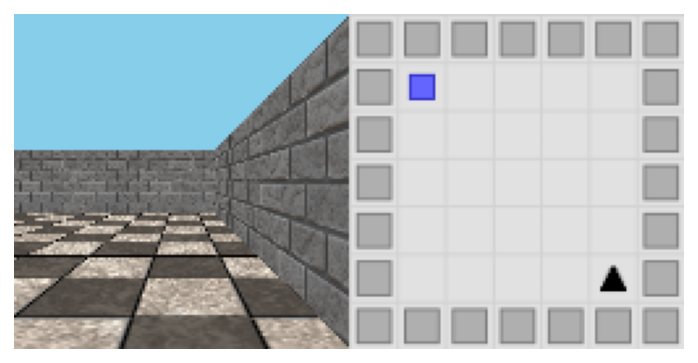

In [19]:
env = GridEnv(
    obs_type=GridObservation.rendered_3d,
    template=GridTemplate.empty,
    size=GridSize.micro,
    torch_obs=True,
)
obs = env.reset()
env.render()

In [20]:
visual_types = [
    GridObservation.window,
    GridObservation.visual,
    GridObservation.rendered_3d,
]


def get_model_params(env):
    if env.obs_mode in visual_types:
        enc_type = "conv64"
    else:
        enc_type = "linear"
    model_params = {
        "enc_type": enc_type,
        "h_size": 128,
        "lr": 3e-4,
        "obs_size": math.prod(env.obs_space.shape),
        "act_size": env.action_space.n,
        "depth": 3,
    }
    return model_params


agent_params_sac = {
    "batch_size": 32,
    "gamma": 0.99,
    "tau": 0.005,
    "target_update_interval": 2,
    "replay_buffer_size": 100000,
    "update_interval": 4,
    "warmup_steps": 1000,
    "alpha": 0.02,
}

agent_params_ppo = {
    "gamma": 0.99,
    "lambda": 0.95,
    "buffer_size": 256,
    "ent_coef": 0.02,
    "num_passes": 2,
    "clip_param": 0.2,
    "batch_size": 32,
}

In [23]:
repeats = 1
episodes = 100
max_steps = 50
algo = "ppo"  # "sac" or "ppo"

all_returns = []
for i in range(repeats):
    ep_returns = []
    model_params = get_model_params(env)
    if algo == "ppo":
        agent = PPOAgent(model_params, agent_params_ppo)
    elif algo == "sac":
        agent = SACAgent(model_params, agent_params_sac)
    else:
        raise NotImplementedError
    for j in range(episodes):
        agent, ep_steps, ep_return = run_episode(
            env, agent, max_steps, time_penalty=-0.01
        )
        ep_returns.append(ep_return)
    all_returns.append(ep_returns)

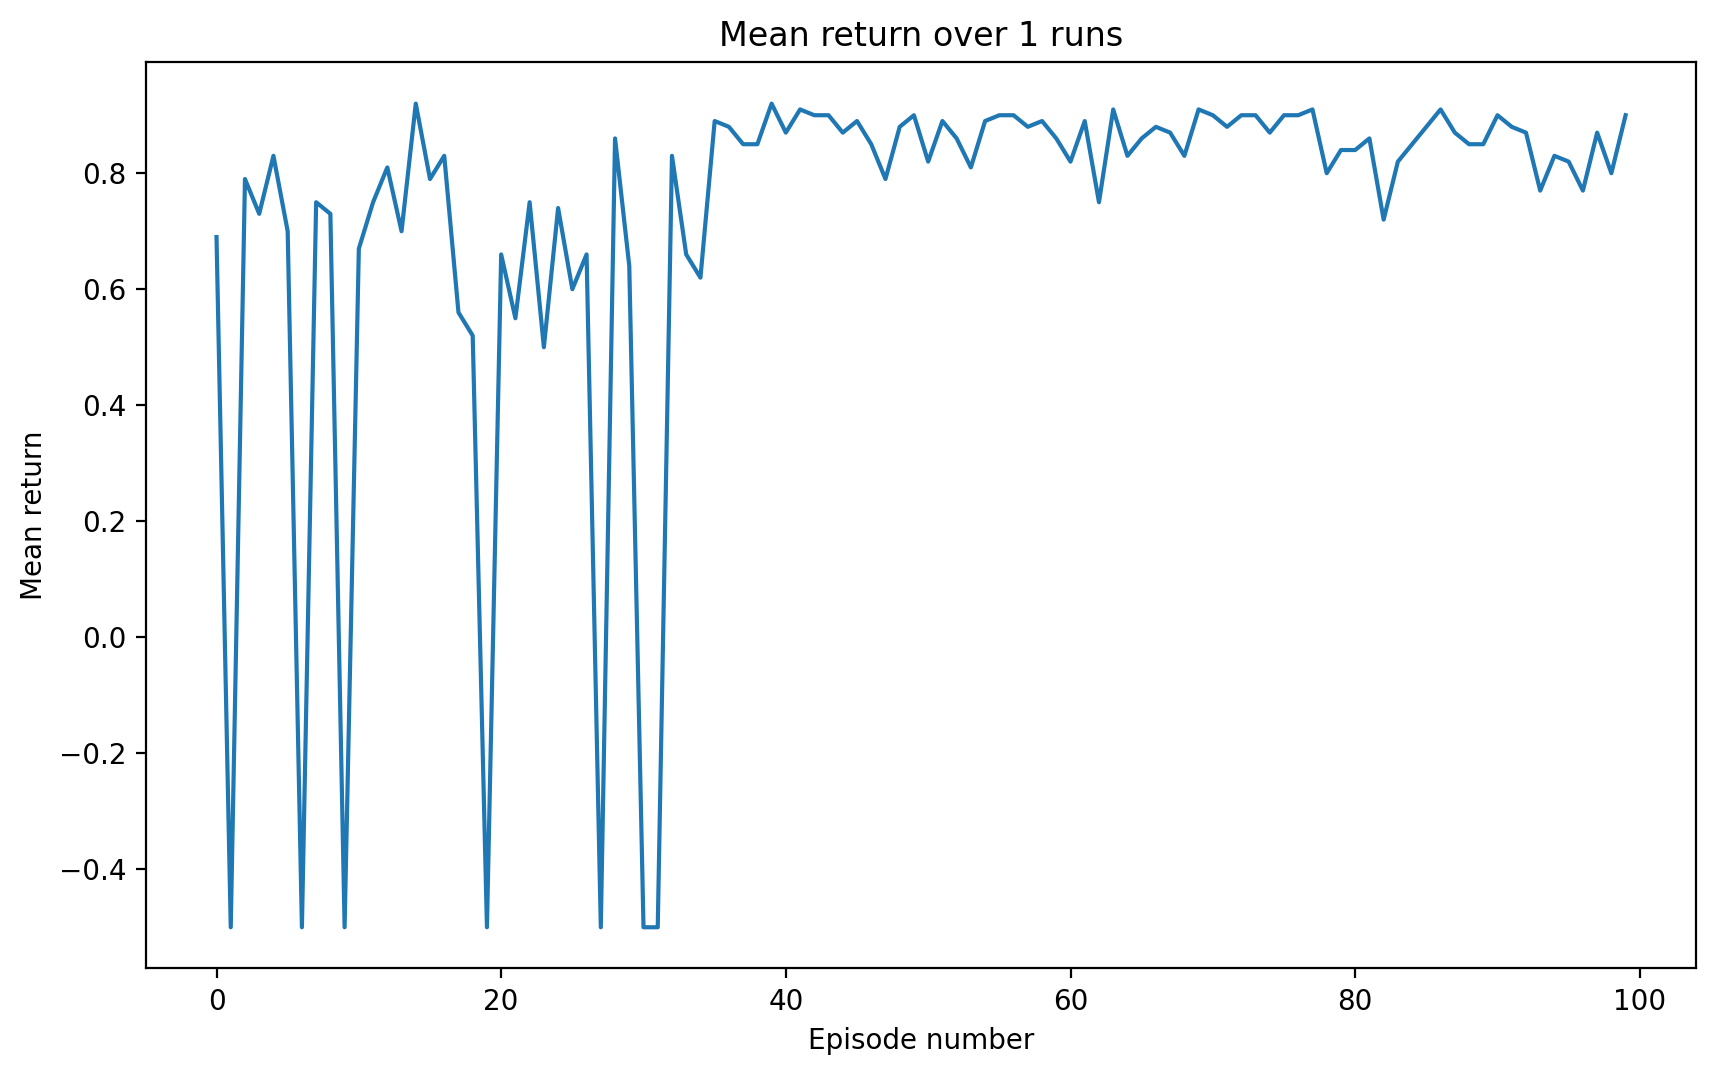

In [24]:
all_returns = np.stack(all_returns)
mean_returns = np.mean(all_returns, axis=0)
std_returns = np.std(all_returns, axis=0)
se_return = std_returns / np.sqrt(repeats)

# create figure
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
plt.plot(mean_returns)
plt.fill_between(
    range(episodes), mean_returns - se_return, mean_returns + se_return, alpha=0.2
)
plt.xlabel("Episode number")
plt.ylabel("Mean return")
plt.title(f"Mean return over {repeats} runs")
plt.show()